In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, levene
from tqdm.auto import tqdm
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
import collections as coll
import math
from sklearn.preprocessing import StandardScaler
import spacy
import os

In [60]:
nlp = spacy.load("en_core_web_sm")


def RemoveSpecialCHs(text):
    text = word_tokenize(text)
    st = [
        ",",
        ".",
        "'",
        "!",
        '"',
        "#",
        "$",
        "%",
        "&",
        "(",
        ")",
        "*",
        "+",
        "-",
        ".",
        "/",
        ":",
        ";",
        "<",
        "=",
        ">",
        "?",
        "@",
        "[",
        "\\",
        "]",
        "^",
        "_",
        "`",
        "{",
        "|",
        "}",
        "~",
        "\t",
        "\n",
    ]

    words = [word for word in text if word not in st]
    return words


def compute_avg_dependency_link_length(text):
    try:
        doc = nlp(text)
        link_lengths = []
        for sent in doc.sents:
            sent_link_lengths = []
            for token in sent:
                if token.dep_ != "ROOT":
                    head = token.head
                    sent_link_lengths.append(abs(head.i - token.i))
            if sent_link_lengths:  # Only append if sentence had any links
                link_lengths.append(np.mean(sent_link_lengths))
        return np.mean(link_lengths)
    except:
        return np.nan


def typeTokenRatio(text):
    try:
        words = word_tokenize(text)
        return len(set(words)) / len(words)
    except:
        return np.nan


def hapaxLegemena(text):
    try:
        words = RemoveSpecialCHs(text)
        V1 = 0
        # dictionary comprehension . har word kay against value 0 kardi
        freqs = {key: 0 for key in words}
        for word in words:
            freqs[word] += 1
        for word in freqs:
            if freqs[word] == 1:
                V1 += 1
        N = len(words)
        V = float(len(set(words)))
        R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
        h = V1 / N
        return R, h
    except:
        return np.nan, np.nan


def ShannonEntropy(text):
    try:
        words = RemoveSpecialCHs(text)
        lenght = len(words)
        freqs = coll.Counter()
        freqs.update(words)
        arr = np.array(list(freqs.values()))
        distribution = 1.0 * arr
        distribution /= max(1, lenght)
        import scipy as sc

        H = sc.stats.entropy(distribution, base=2)
        # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
        return H
    except:
        return np.nan


def SimpsonsIndex(text):
    try:
        words = RemoveSpecialCHs(text)
        freqs = coll.Counter()
        freqs.update(words)
        N = len(words)
        n = sum([1.0 * i * (i - 1) for i in freqs.values()])
        D = 1 - (n / (N * (N - 1)))
        return D
    except:
        return np.nan

In [61]:
complexity_features = [
    "avg_dependency_link_length",
    "type_token_ratio",
    "hapax_legemena",
    "shannon_entropy",
    "simpsons_index",
]

In [62]:
def add_complexity_features(df, text_column):
    df[f"{text_column}_avg_dependency_link_length"] = [
        compute_avg_dependency_link_length(text)
        for text in tqdm(df[text_column], leave=False)
    ]

    df[f"{text_column}_type_token_ratio"] = [
        typeTokenRatio(text) for text in tqdm(df[text_column], leave=False)
    ]
    df[f"{text_column}_hapax_legemena"] = [
        hapaxLegemena(text)[1] for text in tqdm(df[text_column], leave=False)
    ]
    df[f"{text_column}_shannon_entropy"] = [
        ShannonEntropy(text) for text in tqdm(df[text_column], leave=False)
    ]
    df[f"{text_column}_simpsons_index"] = [
        SimpsonsIndex(text) for text in tqdm(df[text_column], leave=False)
    ]
    return df


def add_complexity_features_for_all_texts(df):
    df = add_complexity_features(df, "original_text")
    df = add_complexity_features(df, "rewritten_text")

    return df

In [63]:
def load_data():
    all_data = None
    for llm in ["gpt", "gemini", "llama"]:
        for dataset_name in ["papers", "news", "reddit"]:
            for rewrite_type in ["syntax_grammar", "rephrase"]:  # ,
                log_file_name = f"{dataset_name}_rewritten_{rewrite_type}_{llm}.json"
                with open(os.path.join(dataset_name, log_file_name)) as f:
                    data = pd.read_json(f, orient="index")
                    data["index"] = data.index
                    data["dataset"] = dataset_name
                    data["rewrite_type"] = rewrite_type
                    data["llm"] = llm
                    data.reset_index(drop=True, inplace=True)
                    if all_data is None:
                        all_data = data
                    else:
                        all_data = pd.concat([all_data, data], ignore_index=True)
    return all_data

In [64]:
reddit_data = pd.read_csv("reddit/filtered_comments.csv")
# text columns is "body" and the id column is "name"
reddit_data["id"] = reddit_data["name"]
reddit_data["text"] = reddit_data["body"]
reddit_data["id"] = reddit_data["id"].astype(str)

news_data = pd.read_csv("news/news_data.csv")
# text column is "text", and since there's no id column, we'll use the index
news_data["id"] = news_data.index
news_data["id"] = news_data["id"].astype(str)

papers_data = pd.read_csv("papers/cl_cv_papers.csv")
papers_data["final_date"] = pd.to_datetime(papers_data["update_date"])
papers_data["year"] = papers_data["final_date"].dt.year
papers_data["month"] = papers_data["final_date"].dt.month
# text column is "abstract", and the id column is "id"
papers_data["text"] = papers_data["abstract"]
papers_data["id"] = papers_data["id"].astype(str)

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/1419015784.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  papers_data = pd.read_csv("papers/cl_cv_papers.csv")


In [65]:
all_data_indices_to_years = {}
for data in [reddit_data, news_data, papers_data]:
    all_data_indices_to_years.update(dict(zip(data["id"], data["year"])))

In [ ]:
all_data = load_data()
all_data = add_complexity_features_for_all_texts(all_data)
all_data.head(3)

In [67]:
all_data["id"] = all_data["index"].astype(str)
all_data["year"] = all_data["id"].map(all_data_indices_to_years)

In [68]:
def get_agg_features_and_entropies(df):
    llms = []
    modes = []
    cols = []
    datasets = []
    distribution_values = []
    dataset_original_or_not = []
    all_indices = []
    for dataset in tqdm(df["dataset"].unique(), leave=False):
        for llm in tqdm(df[df["dataset"] == dataset]["llm"].unique(), leave=False):
            for mode in tqdm(
                df[(df["dataset"] == dataset) & (df["llm"] == llm)][
                    "rewrite_type"
                ].unique(),
                leave=False,
            ):
                for col in tqdm(complexity_features, leave=False):
                    for prefix in ["original_text", "rewritten_text"]:
                        data = df[
                            (df["dataset"] == dataset)
                            & (df["llm"] == llm)
                            & (df["rewrite_type"] == mode)
                        ]
                        data = data[data[f"{prefix}_{col}"].notna()]

                        # make the year would be before 2022
                        data = data[data["year"] < 2023]

                        values = data[f"{prefix}_{col}"].tolist()
                        indices = data["index"].tolist()

                        # scaler = StandardScaler()
                        # normalized_values = scaler.fit_transform(
                        #     np.array(values).reshape(-1, 1)
                        # ).flatten()
                        normalized_values = values

                        llms.append(llm)
                        modes.append(mode)
                        cols.append(col)
                        datasets.append(dataset)
                        distribution_values.append(normalized_values)
                        dataset_original_or_not.append(prefix)
                        all_indices.append(indices)

    return (
        llms,
        modes,
        cols,
        datasets,
        dataset_original_or_not,
        distribution_values,
        all_indices,
    )

In [ ]:
(
    llms,
    modes,
    cols,
    datasets,
    dataset_original_or_not,
    distribution_values,
    all_indices,
) = get_agg_features_and_entropies(all_data)
df = pd.DataFrame(
    {
        "llm": llms,
        "mode": modes,
        "col": cols,
        "dataset": datasets,
        "is_original": dataset_original_or_not,
        "distribution": distribution_values,
        "index": all_indices,
    }
)

In [70]:
df = df[df["col"].isin(complexity_features)]

filtered_llms = []
filtered_modes = []
filtered_datasets = []
filtered_is_originals = []
mean_values = []
avg_dep_values = []
type_token_values = []
hapax_values = []
shannon_values = []
simpsons_values = []


for llm in df["llm"].unique():
    for mode in df["mode"].unique():
        for dataset in df["dataset"].unique():
            for is_original in df["is_original"].unique():

                sub_df = df[
                    (df["llm"] == llm)
                    & (df["mode"] == mode)
                    & (df["dataset"] == dataset)
                    & (df["is_original"] == is_original)
                ]
                avg_dep_subdf = pd.DataFrame(
                    {
                        "value_avg_dep": sub_df[
                            sub_df["col"] == "avg_dependency_link_length"
                        ]["distribution"].values[0],
                        "index": sub_df[sub_df["col"] == "avg_dependency_link_length"][
                            "index"
                        ].values[0],
                    }
                )
                type_token_subdf = pd.DataFrame(
                    {
                        "value_type_token": sub_df[sub_df["col"] == "type_token_ratio"][
                            "distribution"
                        ].values[0],
                        "index": sub_df[sub_df["col"] == "type_token_ratio"][
                            "index"
                        ].values[0],
                    }
                )
                hapax_subdf = pd.DataFrame(
                    {
                        "value_hapax": sub_df[sub_df["col"] == "hapax_legemena"][
                            "distribution"
                        ].values[0],
                        "index": sub_df[sub_df["col"] == "hapax_legemena"][
                            "index"
                        ].values[0],
                    }
                )
                shannon_subdf = pd.DataFrame(
                    {
                        "value_shannon": sub_df[sub_df["col"] == "shannon_entropy"][
                            "distribution"
                        ].values[0],
                        "index": sub_df[sub_df["col"] == "shannon_entropy"][
                            "index"
                        ].values[0],
                    }
                )
                simpsons_subdf = pd.DataFrame(
                    {
                        "value_simpsons": sub_df[sub_df["col"] == "simpsons_index"][
                            "distribution"
                        ].values[0],
                        "index": sub_df[sub_df["col"] == "simpsons_index"][
                            "index"
                        ].values[0],
                    }
                )

                merged_df = (
                    pd.merge(
                        avg_dep_subdf,
                        type_token_subdf,
                        on="index",
                    )
                    .merge(hapax_subdf, on="index")
                    .merge(
                        shannon_subdf,
                        on="index",
                    )
                    .merge(
                        simpsons_subdf,
                        on="index",
                    )
                )

                from sklearn.preprocessing import StandardScaler

                scaler = StandardScaler()
                value_avg_dep_normalized = scaler.fit_transform(
                    merged_df["value_avg_dep"].values.reshape(-1, 1)
                ).flatten()
                scaler = StandardScaler()
                value_type_token_normalized = scaler.fit_transform(
                    merged_df["value_type_token"].values.reshape(-1, 1)
                ).flatten()
                scaler = StandardScaler()
                value_hapax_normalized = scaler.fit_transform(
                    merged_df["value_hapax"].values.reshape(-1, 1)
                ).flatten()
                scaler = StandardScaler()
                value_shannon_normalized = scaler.fit_transform(
                    merged_df["value_shannon"].values.reshape(-1, 1)
                ).flatten()
                scaler = StandardScaler()
                value_simpsons_normalized = scaler.fit_transform(
                    merged_df["value_simpsons"].values.reshape(-1, 1)
                ).flatten()

                # # get the mean of all the value_* columns
                merged_df["value"] = np.mean(
                    [
                        merged_df["value_avg_dep"],
                        merged_df["value_type_token"],
                        merged_df["value_hapax"],
                        merged_df["value_shannon"],
                        merged_df["value_simpsons"],
                    ],
                    axis=0,
                )

                mean_values.append(merged_df["value"].values)
                avg_dep_values.append(merged_df["value_avg_dep"].values)
                type_token_values.append(merged_df["value_type_token"].values)
                hapax_values.append(merged_df["value_hapax"].values)
                shannon_values.append(merged_df["value_shannon"].values)
                simpsons_values.append(merged_df["value_simpsons"].values)
                filtered_llms.append(llm)
                filtered_modes.append(mode)
                filtered_datasets.append(dataset)
                filtered_is_originals.append(is_original)

filtered_df = pd.DataFrame(
    {
        "llm": filtered_llms,
        "mode": filtered_modes,
        "dataset": filtered_datasets,
        "is_original": filtered_is_originals,
        "mean": mean_values,
        "avg_dep": avg_dep_values,
        "type_token": type_token_values,
        "hapax": hapax_values,
        "shannon": shannon_values,
        "simpsons": simpsons_values,
    }
)

In [78]:
from IPython.display import display


for col in ["mean", "avg_dep", "type_token", "hapax", "shannon", "simpsons"]:
    print("---------------------------------")
    print("analysis for: ", col)

    final_datasets = []
    final_llms = []
    final_modes = []
    final_significances = []
    final_statistics = []

    for dataset in filtered_df["dataset"].unique():
        for llm in filtered_df["llm"].unique():
            for mode in filtered_df["mode"].unique():
                final_datasets.append(dataset)
                final_llms.append(llm)
                final_modes.append(mode)
                original_values = filtered_df[
                    (filtered_df["dataset"] == dataset)
                    & (filtered_df["llm"] == llm)
                    & (filtered_df["mode"] == mode)
                    & (filtered_df["is_original"] == "original_text")
                ][col].values[0]
                rewritten_values = filtered_df[
                    (filtered_df["dataset"] == dataset)
                    & (filtered_df["llm"] == llm)
                    & (filtered_df["mode"] == mode)
                    & (filtered_df["is_original"] == "rewritten_text")
                ][col].values[0]
                stats, p = levene(original_values, rewritten_values)
                p = np.round(p, 4)
                stats = np.round(stats, 3)
                final_statistics.append(stats)
                original_vars = np.round(np.var(original_values), 4)
                rewritten_vars = np.round(np.var(rewritten_values), 4)
                if p <= 0.05:
                    if original_vars >= rewritten_vars:
                        final_significances.append(
                            f"{original_vars} -> {rewritten_vars} ({p})*"
                        )
                    elif original_vars < rewritten_vars:
                        final_significances.append(
                            f"{original_vars} -> {rewritten_vars} ({p})**"
                        )
                else:
                    final_significances.append(
                        f"{original_vars} -> {rewritten_vars} ({p})"
                    )

    final_df = pd.DataFrame(
        {
            "dataset": final_datasets,
            "llm": final_llms,
            "mode": final_modes,
            "significance": final_significances,
            "statistics": final_statistics,
        }
    )

    display(
        final_df.pivot_table(
            index=["llm", "mode"],
            columns="dataset",
            values=["significance", "statistics"],
            aggfunc=lambda x: x,
        )
    )
    print(
        final_df.pivot_table(
            index=["llm", "mode"],
            columns="dataset",
            values=["significance", "statistics"],
            aggfunc=lambda x: x,
        ).to_latex()
    )

---------------------------------
analysis for:  mean


significance                             \
dataset                                      news                     papers   
llm    mode                                                                    
gemini rephrase         0.0279 -> 0.0289 (0.6599)  0.009 -> 0.0071 (0.0247)*   
       syntax_grammar   0.0279 -> 0.1457 (0.2455)   0.009 -> 0.0074 (0.034)*   
gpt    rephrase         0.0279 -> 0.0227 (0.4912)   0.009 -> 0.007 (0.0251)*   
       syntax_grammar   0.0279 -> 0.0288 (0.8927)  0.009 -> 0.0071 (0.0124)*   
llama  rephrase        0.0279 -> 0.0095 (0.0074)*  0.009 -> 0.0064 (0.0006)*   
       syntax_grammar   0.0279 -> 0.0226 (0.6469)   0.009 -> 0.0111 (0.0664)   

                                                  statistics                  
dataset                                    reddit       news  papers  reddit  
llm    mode                                                                   
gemini rephrase         0.0091 -> 0.0076 (0.1457)      0.194   5.062   2.126  
       syntax_grammar  0.0091 -> 0.0069 (0.0207)*      1.356   4.507   5.399  
gpt    rephrase        0.0091 -> 0.0063 (0.0149)*      0.476   5.031   5.978  
       syntax_grammar  0.0091 -> 0.0068 (0.0179)*      0.018   6.276   5.652  
llama  rephrase           0.0091 -> 0.0045 (0.0)*      7.322  12.007  19.387  
       syntax_grammar  0.0091 -> 0.0069 (0.0476)*      0.211   3.377   3.952

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.0279 -> 0.0289 (0.6599) & 0.009 -> 0.0071 (0.0247)* & 0.0091 -> 0.0076 (0.1457) & 0.194000 & 5.062000 & 2.126000 \\
 & syntax_grammar & 0.0279 -> 0.1457 (0.2455) & 0.009 -> 0.0074 (0.034)* & 0.0091 -> 0.0069 (0.0207)* & 1.356000 & 4.507000 & 5.399000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.0279 -> 0.0227 (0.4912) & 0.009 -> 0.007 (0.0251)* & 0.0091 -> 0.0063 (0.0149)* & 0.476000 & 5.031000 & 5.978000 \\
 & syntax_grammar & 0.0279 -> 0.0288 (0.8927) & 0.009 -> 0.0071 (0.0124)* & 0.0091 -> 0.0068 (0.0179)* & 0.018000 & 6.276000 & 5.652000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.0279 -> 0.0095 (0.0074)* & 0.009 -> 0.0064 (0.0006)* & 0.0091 -> 0.0045 (0.0)* & 7.322000 & 12.007000 & 19.387000 \\
 & syntax_gra

significance                               \
dataset                                     news                       papers   
llm    mode                                                                     
gemini rephrase        0.1245 -> 0.2501 (0.0538)    0.0984 -> 0.1044 (0.3547)   
       syntax_grammar  0.1245 -> 3.1575 (0.1851)    0.0984 -> 0.0905 (0.3449)   
gpt    rephrase          0.1245 -> 0.255 (0.514)    0.0984 -> 0.0829 (0.1703)   
       syntax_grammar  0.1245 -> 0.2245 (0.4283)   0.0984 -> 0.0784 (0.0105)*   
llama  rephrase        0.1245 -> 0.1087 (0.7688)  0.0984 -> 0.1277 (0.0139)**   
       syntax_grammar  0.1245 -> 0.1332 (0.7941)    0.0984 -> 0.0838 (0.1566)   

                                                  statistics                 
dataset                                    reddit       news papers  reddit  
llm    mode                                                                  
gemini rephrase         0.0792 -> 0.1083 (0.5782)      3.764  0.857   0.310  
       syntax_grammar  0.0792 -> 0.0475 (0.0005)*      1.768  0.893  12.365  
gpt    rephrase        0.0792 -> 0.0596 (0.0196)*      0.428  1.883   5.498  
       syntax_grammar  0.0792 -> 0.0569 (0.0262)*      0.630  6.578   4.980  
llama  rephrase        0.0796 -> 0.0519 (0.0036)*      0.087  6.073   8.564  
       syntax_grammar   0.0792 -> 0.0647 (0.0822)      0.068  2.009   3.037

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.1245 -> 0.2501 (0.0538) & 0.0984 -> 0.1044 (0.3547) & 0.0792 -> 0.1083 (0.5782) & 3.764000 & 0.857000 & 0.310000 \\
 & syntax_grammar & 0.1245 -> 3.1575 (0.1851) & 0.0984 -> 0.0905 (0.3449) & 0.0792 -> 0.0475 (0.0005)* & 1.768000 & 0.893000 & 12.365000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.1245 -> 0.255 (0.514) & 0.0984 -> 0.0829 (0.1703) & 0.0792 -> 0.0596 (0.0196)* & 0.428000 & 1.883000 & 5.498000 \\
 & syntax_grammar & 0.1245 -> 0.2245 (0.4283) & 0.0984 -> 0.0784 (0.0105)* & 0.0792 -> 0.0569 (0.0262)* & 0.630000 & 6.578000 & 4.980000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.1245 -> 0.1087 (0.7688) & 0.0984 -> 0.1277 (0.0139)** & 0.0796 -> 0.0519 (0.0036)* & 0.087000 & 6.073000 & 8.564000 \\
 & syntax

significance                              \
dataset                                      news                      papers   
llm    mode                                                                     
gemini rephrase        0.0168 -> 0.0096 (0.0091)*  0.0034 -> 0.0025 (0.0027)*   
       syntax_grammar   0.0168 -> 0.0116 (0.0538)   0.0034 -> 0.0028 (0.1086)   
gpt    rephrase         0.0168 -> 0.008 (0.0015)*    0.0034 -> 0.003 (0.2355)   
       syntax_grammar  0.0168 -> 0.0107 (0.0214)*   0.0034 -> 0.0027 (0.019)*   
llama  rephrase        0.0168 -> 0.0083 (0.0013)*    0.0034 -> 0.0027 (0.088)   
       syntax_grammar  0.0168 -> 0.0089 (0.0106)*    0.0034 -> 0.0096 (0.0)**   

                                                  statistics                   
dataset                                    reddit       news   papers  reddit  
llm    mode                                                                    
gemini rephrase            0.0053 -> 0.003 (0.0)*      6.935    9.060  20.162  
       syntax_grammar   0.0053 -> 0.0047 (0.1974)      3.764    2.579   1.668  
gpt    rephrase         0.0053 -> 0.0042 (0.006)*     10.311    1.409   7.637  
       syntax_grammar  0.0053 -> 0.0036 (0.0001)*      5.375    5.521  14.680  
llama  rephrase        0.0053 -> 0.0032 (0.0001)*     10.604    2.917  14.844  
       syntax_grammar     0.0053 -> 0.005 (0.524)      6.651  109.819   0.407

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.0168 -> 0.0096 (0.0091)* & 0.0034 -> 0.0025 (0.0027)* & 0.0053 -> 0.003 (0.0)* & 6.935000 & 9.060000 & 20.162000 \\
 & syntax_grammar & 0.0168 -> 0.0116 (0.0538) & 0.0034 -> 0.0028 (0.1086) & 0.0053 -> 0.0047 (0.1974) & 3.764000 & 2.579000 & 1.668000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.0168 -> 0.008 (0.0015)* & 0.0034 -> 0.003 (0.2355) & 0.0053 -> 0.0042 (0.006)* & 10.311000 & 1.409000 & 7.637000 \\
 & syntax_grammar & 0.0168 -> 0.0107 (0.0214)* & 0.0034 -> 0.0027 (0.019)* & 0.0053 -> 0.0036 (0.0001)* & 5.375000 & 5.521000 & 14.680000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.0168 -> 0.0083 (0.0013)* & 0.0034 -> 0.0027 (0.088) & 0.0053 -> 0.0032 (0.0001)* & 10.604000 & 2.917000 & 14.844000 \\
 & syntax

significance                              \
dataset                                      news                      papers   
llm    mode                                                                     
gemini rephrase        0.0219 -> 0.0107 (0.0068)*   0.0055 -> 0.0057 (0.6838)   
       syntax_grammar  0.0219 -> 0.0124 (0.0335)*   0.0055 -> 0.0054 (0.6571)   
gpt    rephrase        0.0219 -> 0.0116 (0.0113)*   0.0055 -> 0.0057 (0.8879)   
       syntax_grammar  0.0219 -> 0.0146 (0.0473)*  0.0055 -> 0.0044 (0.0169)*   
llama  rephrase        0.0219 -> 0.0122 (0.0169)*    0.0055 -> 0.0059 (0.419)   
       syntax_grammar   0.0219 -> 0.0149 (0.1279)    0.0055 -> 0.0155 (0.0)**   

                                                  statistics                  
dataset                                    reddit       news   papers reddit  
llm    mode                                                                   
gemini rephrase        0.0058 -> 0.0044 (0.0333)*      7.486    0.166  4.564  
       syntax_grammar   0.0058 -> 0.0064 (0.6129)      4.584    0.197  0.256  
gpt    rephrase         0.0058 -> 0.0054 (0.1782)      6.534    0.020  1.819  
       syntax_grammar  0.0058 -> 0.0049 (0.0357)*      3.982    5.730  4.443  
llama  rephrase         0.0058 -> 0.0048 (0.1692)      5.800    0.654  1.898  
       syntax_grammar   0.0058 -> 0.0061 (0.7886)      2.337  110.674  0.072

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.0219 -> 0.0107 (0.0068)* & 0.0055 -> 0.0057 (0.6838) & 0.0058 -> 0.0044 (0.0333)* & 7.486000 & 0.166000 & 4.564000 \\
 & syntax_grammar & 0.0219 -> 0.0124 (0.0335)* & 0.0055 -> 0.0054 (0.6571) & 0.0058 -> 0.0064 (0.6129) & 4.584000 & 0.197000 & 0.256000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.0219 -> 0.0116 (0.0113)* & 0.0055 -> 0.0057 (0.8879) & 0.0058 -> 0.0054 (0.1782) & 6.534000 & 0.020000 & 1.819000 \\
 & syntax_grammar & 0.0219 -> 0.0146 (0.0473)* & 0.0055 -> 0.0044 (0.0169)* & 0.0058 -> 0.0049 (0.0357)* & 3.982000 & 5.730000 & 4.443000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.0219 -> 0.0122 (0.0169)* & 0.0055 -> 0.0059 (0.419) & 0.0058 -> 0.0048 (0.1692) & 5.800000 & 0.654000 & 1.898000 \\
 & synta

significance                             \
dataset                                      news                     papers   
llm    mode                                                                    
gemini rephrase         0.7819 -> 0.4592 (0.0854)  0.0907 -> 0.0784 (0.1474)   
       syntax_grammar   0.7819 -> 0.6344 (0.4731)  0.0907 -> 0.0945 (0.6207)   
gpt    rephrase        0.7819 -> 0.3637 (0.0071)*  0.0907 -> 0.0824 (0.4162)   
       syntax_grammar   0.7819 -> 0.5653 (0.2067)  0.0907 -> 0.0895 (0.8159)   
llama  rephrase        0.7819 -> 0.2998 (0.0009)*   0.0907 -> 0.078 (0.2634)   
       syntax_grammar   0.7819 -> 0.5083 (0.1573)  0.0907 -> 0.0754 (0.1146)   

                                                 statistics                 
dataset                                   reddit       news papers  reddit  
llm    mode                                                                 
gemini rephrase         0.177 -> 0.1612 (0.3516)      2.989  2.102   0.870  
       syntax_grammar   0.177 -> 0.1698 (0.9084)      0.517  0.245   0.013  
gpt    rephrase         0.177 -> 0.1965 (0.8433)      7.406  0.662   0.039  
       syntax_grammar  0.177 -> 0.1251 (0.0029)*      1.605  0.054   9.007  
llama  rephrase          0.1755 -> 0.0937 (0.0)*     11.274  1.252  22.530  
       syntax_grammar   0.177 -> 0.1486 (0.1654)      2.015  2.494   1.931

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.7819 -> 0.4592 (0.0854) & 0.0907 -> 0.0784 (0.1474) & 0.177 -> 0.1612 (0.3516) & 2.989000 & 2.102000 & 0.870000 \\
 & syntax_grammar & 0.7819 -> 0.6344 (0.4731) & 0.0907 -> 0.0945 (0.6207) & 0.177 -> 0.1698 (0.9084) & 0.517000 & 0.245000 & 0.013000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.7819 -> 0.3637 (0.0071)* & 0.0907 -> 0.0824 (0.4162) & 0.177 -> 0.1965 (0.8433) & 7.406000 & 0.662000 & 0.039000 \\
 & syntax_grammar & 0.7819 -> 0.5653 (0.2067) & 0.0907 -> 0.0895 (0.8159) & 0.177 -> 0.1251 (0.0029)* & 1.605000 & 0.054000 & 9.007000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.7819 -> 0.2998 (0.0009)* & 0.0907 -> 0.078 (0.2634) & 0.1755 -> 0.0937 (0.0)* & 11.274000 & 1.252000 & 22.530000 \\
 & syntax_grammar

significance                        \
dataset                               news                papers   
llm    mode                                                        
gemini rephrase        0.0 -> 0.0 (0.8893)     0.0 -> 0.0 (0.0)*   
       syntax_grammar  0.0 -> 0.0 (0.5354)     0.0 -> 0.0 (0.0)*   
gpt    rephrase        0.0 -> 0.0 (0.3797)     0.0 -> 0.0 (0.0)*   
       syntax_grammar  0.0 -> 0.0 (0.8532)  0.0 -> 0.0 (0.0003)*   
llama  rephrase        0.0 -> 0.0 (0.9724)     0.0 -> 0.0 (0.0)*   
       syntax_grammar  0.0 -> 0.0 (0.5851)     0.0 -> 0.0 (0.0)*   

                                            statistics                  
dataset                              reddit       news  papers  reddit  
llm    mode                                                             
gemini rephrase        0.0 -> 0.0 (0.0488)*      0.019  40.053   3.908  
       syntax_grammar   0.0 -> 0.0 (0.1106)      0.385  56.825   2.557  
gpt    rephrase        0.0 -> 0.0 (0.0002)*      0.775  29.359  14.603  
       syntax_grammar  0.0 -> 0.0 (0.0385)*      0.034  13.437   4.314  
llama  rephrase        0.0 -> 0.0 (0.0008)*      0.001  23.603  11.423  
       syntax_grammar   0.0 -> 0.0 (0.6706)      0.299  35.498   0.181

\begin{tabular}{lllllrrr}
\toprule
 &  & \multicolumn{3}{r}{significance} & \multicolumn{3}{r}{statistics} \\
 & dataset & news & papers & reddit & news & papers & reddit \\
llm & mode &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{gemini} & rephrase & 0.0 -> 0.0 (0.8893) & 0.0 -> 0.0 (0.0)* & 0.0 -> 0.0 (0.0488)* & 0.019000 & 40.053000 & 3.908000 \\
 & syntax_grammar & 0.0 -> 0.0 (0.5354) & 0.0 -> 0.0 (0.0)* & 0.0 -> 0.0 (0.1106) & 0.385000 & 56.825000 & 2.557000 \\
\cline{1-8}
\multirow[t]{2}{*}{gpt} & rephrase & 0.0 -> 0.0 (0.3797) & 0.0 -> 0.0 (0.0)* & 0.0 -> 0.0 (0.0002)* & 0.775000 & 29.359000 & 14.603000 \\
 & syntax_grammar & 0.0 -> 0.0 (0.8532) & 0.0 -> 0.0 (0.0003)* & 0.0 -> 0.0 (0.0385)* & 0.034000 & 13.437000 & 4.314000 \\
\cline{1-8}
\multirow[t]{2}{*}{llama} & rephrase & 0.0 -> 0.0 (0.9724) & 0.0 -> 0.0 (0.0)* & 0.0 -> 0.0 (0.0008)* & 0.001000 & 23.603000 & 11.423000 \\
 & syntax_grammar & 0.0 -> 0.0 (0.5851) & 0.0 -> 0.0 (0.0)* & 0.0 -> 0.0 (0.6706) & 0.299000 & 35.498

In [73]:
cols_to_shortened_names = {
    "simpsons": "S",
    "shannon": "N",
    "hapax": "H",
    "type_token": "T",
    "avg_dep": "A",
    "mean": "G",
}

llms_to_correct_names = {
    "gemini": "Gemini",
    "gpt": "GPT-3",
    "llama": "Llama 3",
}

datasets_to_correct_names = {
    "news": "News",
    "papers": "Papers",
    "reddit": "Reddit",
}

modes_to_correct_names = {
    "rephrase": "R",
    "syntax_grammar": "SG",
}

In [74]:
from IPython.display import display

final_datasets = []
final_llms = []
final_modes = []
final_significances = []
final_cols = []

for col in ["mean", "avg_dep", "type_token", "hapax", "shannon", "simpsons"]:
    for dataset in filtered_df["dataset"].unique():
        for llm in filtered_df["llm"].unique():
            for mode in filtered_df["mode"].unique():
                final_datasets.append(datasets_to_correct_names[dataset])
                final_llms.append(llms_to_correct_names[llm])
                final_modes.append(modes_to_correct_names[mode])
                final_cols.append(cols_to_shortened_names[col])
                original_values = filtered_df[
                    (filtered_df["dataset"] == dataset)
                    & (filtered_df["llm"] == llm)
                    & (filtered_df["mode"] == mode)
                    & (filtered_df["is_original"] == "original_text")
                ][col].values[0]
                rewritten_values = filtered_df[
                    (filtered_df["dataset"] == dataset)
                    & (filtered_df["llm"] == llm)
                    & (filtered_df["mode"] == mode)
                    & (filtered_df["is_original"] == "rewritten_text")
                ][col].values[0]
                stats, p = levene(original_values, rewritten_values)
                p = np.round(p, 2)
                original_vars = np.round(np.var(original_values), 4)
                rewritten_vars = np.round(np.var(rewritten_values), 4)
                if p <= 0.05:
                    if original_vars >= rewritten_vars:
                        final_significances.append(
                            f"{original_vars} -> {rewritten_vars} ({p})*"
                        )
                    else:
                        final_significances.append(
                            f"{original_vars} -> {rewritten_vars} ({p})**"
                        )
                else:
                    final_significances.append(
                        f"{original_vars} -> {rewritten_vars} ({p})"
                    )

final_df = pd.DataFrame(
    {
        "dataset": final_datasets,
        "llm": final_llms,
        "mode": final_modes,
        "significance": final_significances,
        "col": final_cols,
    }
)

display(
    final_df.pivot_table(
        index=["llm", "mode"],
        columns=["dataset", "col"],
        values="significance",
        aggfunc=lambda x: x,
    )
)

dataset                            News                            \
col                                   A                         G   
llm     mode                                                        
GPT-3   R        0.1245 -> 0.255 (0.51)   0.0279 -> 0.0227 (0.49)   
        SG      0.1245 -> 0.2245 (0.43)   0.0279 -> 0.0288 (0.89)   
Gemini  R     0.1245 -> 0.2501 (0.05)**   0.0279 -> 0.0289 (0.66)   
        SG      0.1245 -> 3.1575 (0.19)   0.0279 -> 0.1457 (0.25)   
Llama 3 R       0.1245 -> 0.1087 (0.77)  0.0279 -> 0.0095 (0.01)*   
        SG      0.1245 -> 0.1332 (0.79)   0.0279 -> 0.0226 (0.65)   

dataset                                                           \
col                                  H                         N   
llm     mode                                                       
GPT-3   R     0.0219 -> 0.0116 (0.01)*  0.7819 -> 0.3637 (0.01)*   
        SG    0.0219 -> 0.0146 (0.05)*   0.7819 -> 0.5653 (0.21)   
Gemini  R     0.0219 -> 0.0107 (0.01)*   0.7819 -> 0.4592 (0.09)   
        SG    0.0219 -> 0.0124 (0.03)*   0.7819 -> 0.6344 (0.47)   
Llama 3 R     0.0219 -> 0.0122 (0.02)*   0.7819 -> 0.2998 (0.0)*   
        SG     0.0219 -> 0.0149 (0.13)   0.7819 -> 0.5083 (0.16)   

dataset                                                    \
col                           S                         T   
llm     mode                                                
GPT-3   R     0.0 -> 0.0 (0.38)    0.0168 -> 0.008 (0.0)*   
        SG    0.0 -> 0.0 (0.85)  0.0168 -> 0.0107 (0.02)*   
Gemini  R     0.0 -> 0.0 (0.89)  0.0168 -> 0.0096 (0.01)*   
        SG    0.0 -> 0.0 (0.54)  0.0168 -> 0.0116 (0.05)*   
Llama 3 R     0.0 -> 0.0 (0.97)   0.0168 -> 0.0083 (0.0)*   
        SG    0.0 -> 0.0 (0.59)  0.0168 -> 0.0089 (0.01)*   

dataset                          Papers                           \
col                                   A                        G   
llm     mode                                                       
GPT-3   R       0.0984 -> 0.0829 (0.17)   0.009 -> 0.007 (0.03)*   
        SG     0.0984 -> 0.0784 (0.01)*  0.009 -> 0.0071 (0.01)*   
Gemini  R       0.0984 -> 0.1044 (0.35)  0.009 -> 0.0071 (0.02)*   
        SG      0.0984 -> 0.0905 (0.34)  0.009 -> 0.0074 (0.03)*   
Llama 3 R     0.0984 -> 0.1277 (0.01)**   0.009 -> 0.0064 (0.0)*   
        SG      0.0984 -> 0.0838 (0.16)   0.009 -> 0.0111 (0.07)   

dataset                                                          \
col                                  H                        N   
llm     mode                                                      
GPT-3   R      0.0055 -> 0.0057 (0.89)  0.0907 -> 0.0824 (0.42)   
        SG    0.0055 -> 0.0044 (0.02)*  0.0907 -> 0.0895 (0.82)   
Gemini  R      0.0055 -> 0.0057 (0.68)  0.0907 -> 0.0784 (0.15)   
        SG     0.0055 -> 0.0054 (0.66)  0.0907 -> 0.0945 (0.62)   
Llama 3 R      0.0055 -> 0.0059 (0.42)   0.0907 -> 0.078 (0.26)   
        SG    0.0055 -> 0.0155 (0.0)**  0.0907 -> 0.0754 (0.11)   

dataset                                                    \
col                           S                         T   
llm     mode                                                
GPT-3   R     0.0 -> 0.0 (0.0)*    0.0034 -> 0.003 (0.24)   
        SG    0.0 -> 0.0 (0.0)*  0.0034 -> 0.0027 (0.02)*   
Gemini  R     0.0 -> 0.0 (0.0)*   0.0034 -> 0.0025 (0.0)*   
        SG    0.0 -> 0.0 (0.0)*   0.0034 -> 0.0028 (0.11)   
Llama 3 R     0.0 -> 0.0 (0.0)*   0.0034 -> 0.0027 (0.09)   
        SG    0.0 -> 0.0 (0.0)*  0.0034 -> 0.0096 (0.0)**   

dataset                         Reddit                            \
col                                  A                         G   
llm     mode                                                       
GPT-3   R     0.0792 -> 0.0596 (0.02)*  0.0091 -> 0.0063 (0.01)*   
        SG    0.0792 -> 0.0569 (0.03)*  0.0091 -> 0.0068 (0.02)*   
Gemini  R      0.0792 -> 0.1083 (0.58)   0.0091 -> 0.0076 (0.15)   
        SG     0.0792 -> 0.0475 (0.0)*  

In [75]:
# for the second level of the agg_table in columsn, sort them in the order of AGG, AD, TT, H, SH, S
agg_table = final_df.pivot_table(
    index=["llm", "mode"],
    columns=["dataset", "col"],
    values="significance",
    aggfunc=lambda x: x,
)

agg_table = agg_table[
    [
        ("News", "G"),
        ("News", "A"),
        ("News", "T"),
        ("News", "H"),
        ("News", "N"),
        ("News", "S"),
        ("Papers", "G"),
        ("Papers", "A"),
        ("Papers", "T"),
        ("Papers", "H"),
        ("Papers", "N"),
        ("Papers", "S"),
        ("Reddit", "G"),
        ("Reddit", "A"),
        ("Reddit", "T"),
        ("Reddit", "H"),
        ("Reddit", "N"),
        ("Reddit", "S"),
    ]
]

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/3574941191.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_data.applymap(lambda x: 2 if "**" in x else (1 if "*" in x else 0)),
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/3574941191.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dataset_data.applymap(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/3574941191.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_data.applymap(lambda x: 2 if "**" in x else (1 if "*" in x else 0)),
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/3574941191.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dataset_data.applymap(
/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_81388/3574941191.py:24: FutureWarning: DataFrame.applymap has

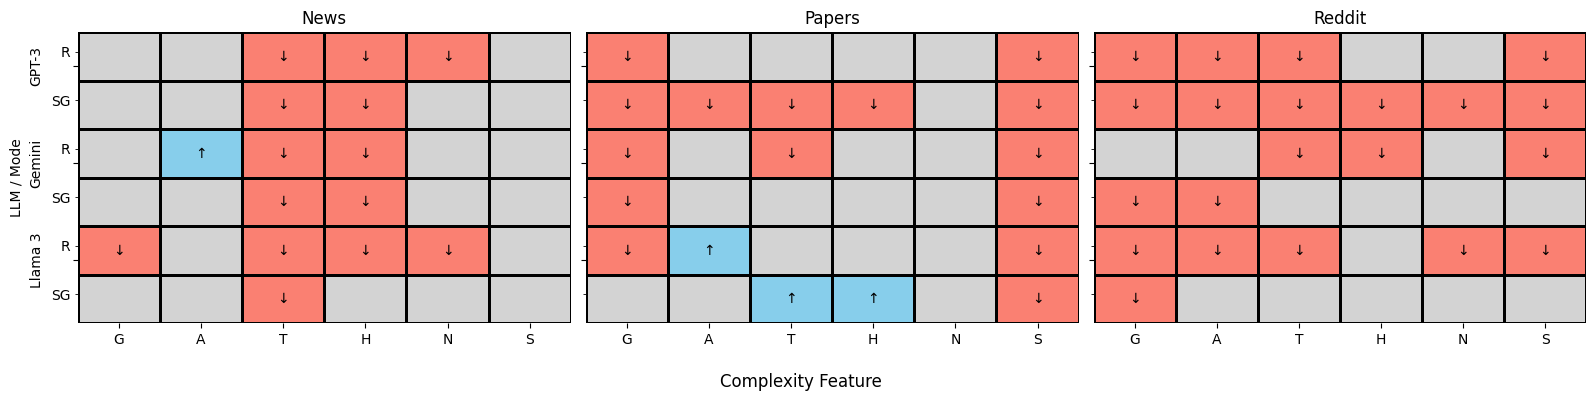

In [76]:
# Create three subplots, one for each dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
datasets = ["News", "Papers", "Reddit"]
axes = [ax1, ax2, ax3]

for dataset, ax in zip(datasets, axes):
    # Get data for this dataset
    dataset_data = agg_table[
        [
            (dataset, "G"),
            (dataset, "A"),
            (dataset, "T"),
            (dataset, "H"),
            (dataset, "N"),
            (dataset, "S"),
        ]
    ]

    # Create heatmap
    sns.heatmap(
        dataset_data.applymap(lambda x: 2 if "**" in x else (1 if "*" in x else 0)),
        cmap=sns.color_palette(["lightgrey", "salmon", "skyblue"]),
        annot=dataset_data.applymap(
            lambda x: "↑" if "**" in x else ("↓" if "*" in x else "")
        ),
        fmt="",
        cbar=False,
        linewidths=1,
        linecolor="black",
        annot_kws={"color": "black"},
        center=1,
        ax=ax,
    )

    # Set x-axis labels
    ax.set_xticks(np.arange(len(dataset_data.columns)) + 0.5)
    ax.set_xticklabels([col[1] for col in dataset_data.columns], rotation=0)
    if ax == ax1:
        ax.set_ylabel("LLM / Mode")
    else:
        ax.set_ylabel("")

    # Set y-axis labels only for first subplot

    # Add first level of row labels
    ax.set_yticks(
        np.arange(len(dataset_data.index.levels[0].unique()))
        * len(dataset_data.index.levels[1].unique())
        + (len(dataset_data.index.levels[1].unique()) - 1) / 2
        + 0.2,
        minor=False,
    )
    ax.set_yticklabels(
        dataset_data.index.levels[0].unique(), minor=False, rotation=90, x=-0.05
    )

    # Add second level of row labels
    ax.set_yticks(np.arange(len(dataset_data.index)) + 0.4, minor=True)
    ax.set_yticklabels([idx[1] for idx in dataset_data.index], minor=True)

    # Set title and labels
    ax.set_title(dataset)
    ax.set_xlabel("")

fig.supxlabel("Complexity Feature")
plt.tight_layout()
plt.savefig("study_2_results_all_features.png", dpi=300)
plt.show()